In [49]:
import numpy as np
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
%matplotlib inline

In [50]:
if torch.cuda.is_available():
    if torch.cuda.device_count() > 1:
        device='cuda:1'
    else:
        device='cuda:0'
else:
    device='cpu'

In [51]:
print(device)

cpu


In [52]:
batch_size = 128

In [53]:
torch.manual_seed(42)

In [54]:
data = np.load('classification_problem.npy', allow_pickle=True)
data

array([[ 983.99054,  942.2865 ,  661.72797, ...,  372.1592 ,  721.33167,
         573.65985],
       [ 977.8995 ,  943.00995,  660.28   , ...,  358.53558,  717.0906 ,
         515.003  ],
       [ 997.3773 ,  943.70807,  663.5131 , ...,  349.9904 ,  668.514  ,
         501.89447],
       ...,
       [1053.4028 ,  943.90314,  654.8272 , ...,  353.91534,  699.50146,
         514.19226],
       [1055.4299 ,  942.15045,  660.39075, ...,  356.51056,  706.0399 ,
         562.4285 ],
       [1023.4271 ,  940.56964,  663.16327, ...,  349.66464,  737.87274,
         586.15576]], dtype=float32)

In [55]:
mean, std = data.mean(axis=0), data.std(axis=0)
data = (data - mean)/std
data

array([[-0.8442512 , -0.14918405,  0.9460576 , ...,  1.5343413 ,
         0.0919254 ,  0.78700274],
       [-1.0824684 ,  0.3417317 ,  0.6886387 , ...,  0.55280656,
        -0.11271124, -0.8005918 ],
       [-0.3207038 ,  0.81545943,  1.2634284 , ..., -0.06284501,
        -2.456579  , -1.1553843 ],
       ...,
       [ 1.8704141 ,  0.9478282 , -0.28078115, ...,  0.21993446,
        -0.96140283, -0.82253486],
       [ 1.9496925 , -0.24150255,  0.70832247, ...,  0.40691063,
        -0.6459162 ,  0.48301807],
       [ 0.6980855 , -1.314203  ,  1.2012303 , ..., -0.08631378,
         0.8900483 ,  1.1252145 ]], dtype=float32)

In [56]:
data.shape

(3000, 12)

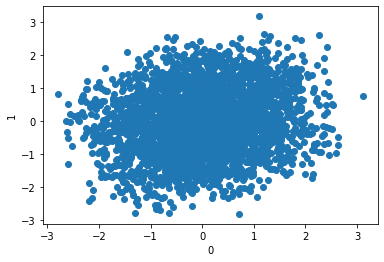

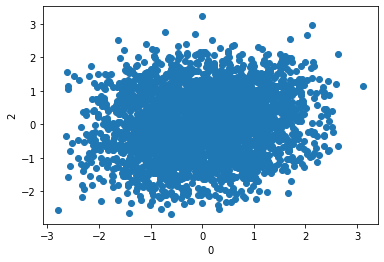

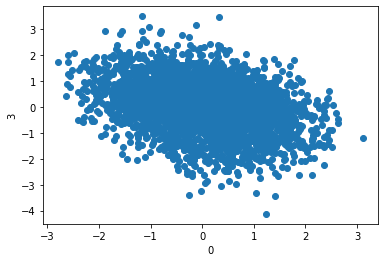

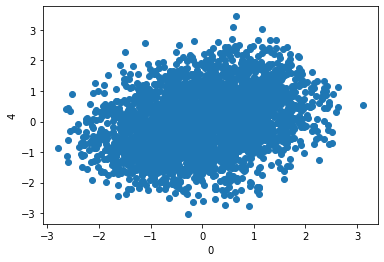

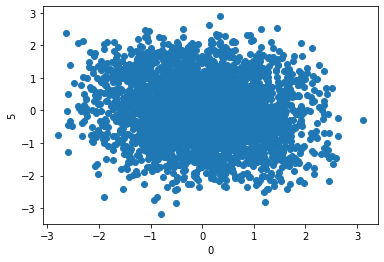

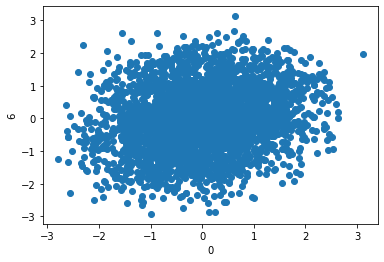

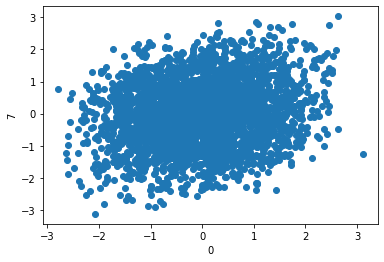

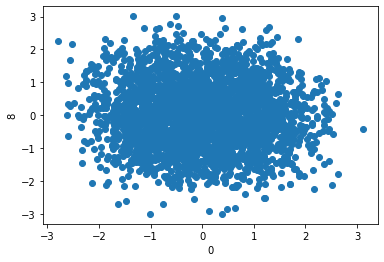

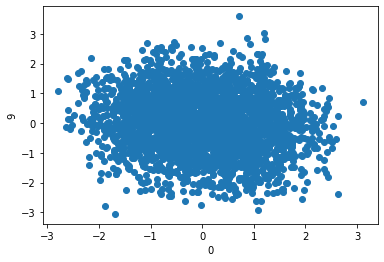

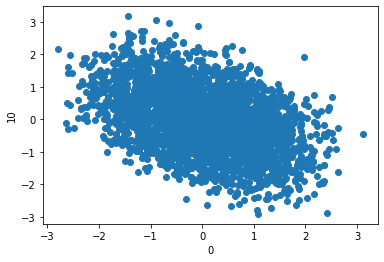

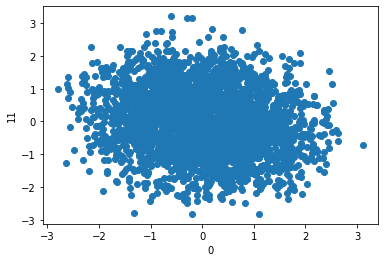

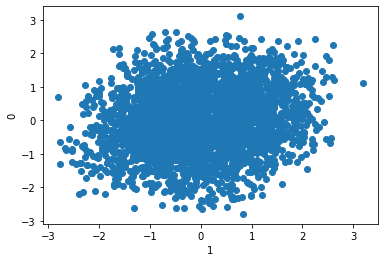

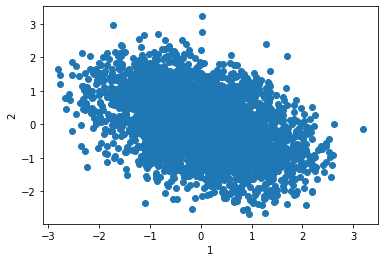

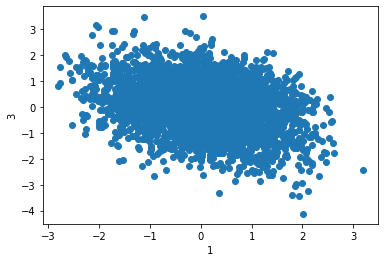

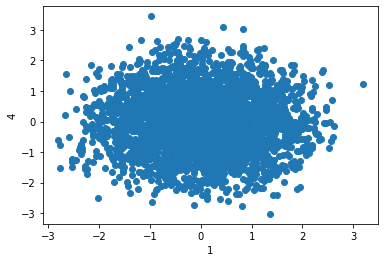

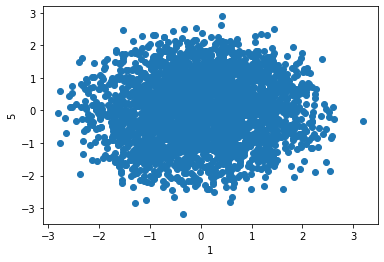

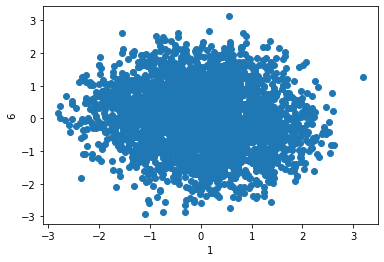

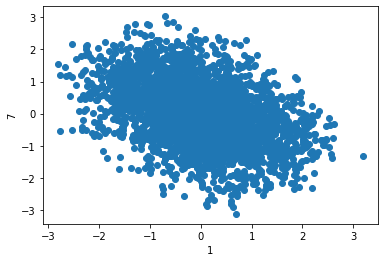

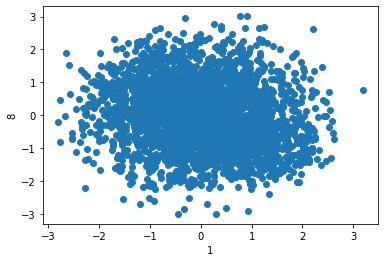

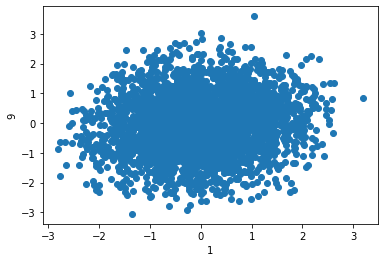

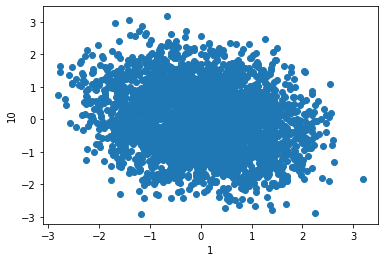

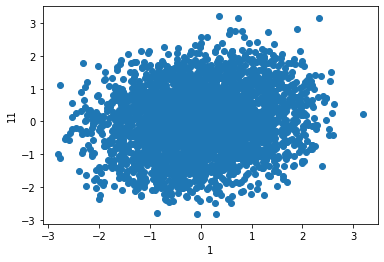

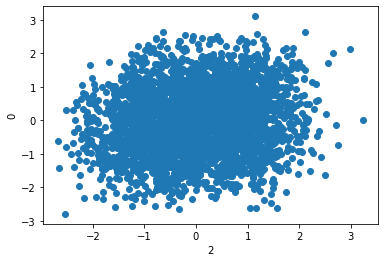

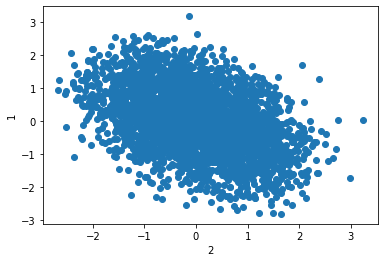

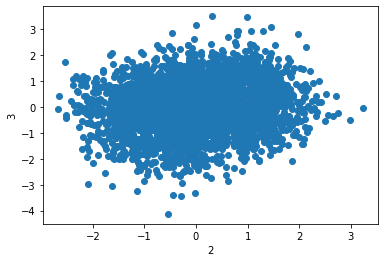

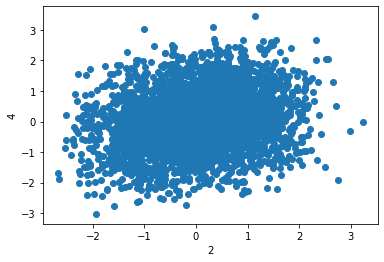

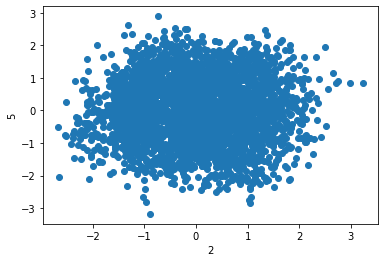

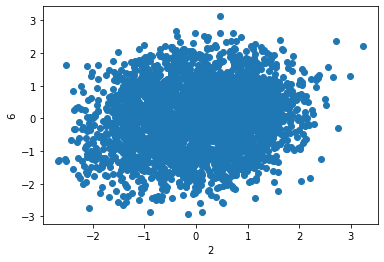

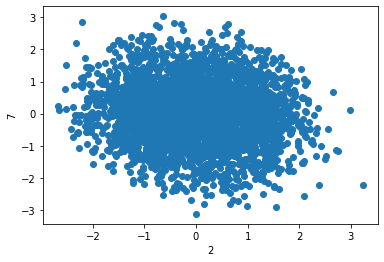

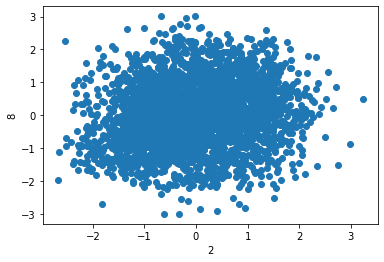

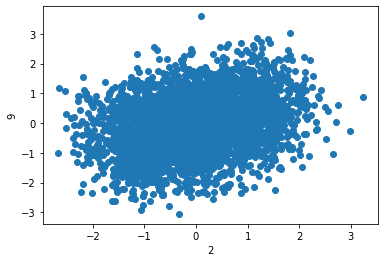

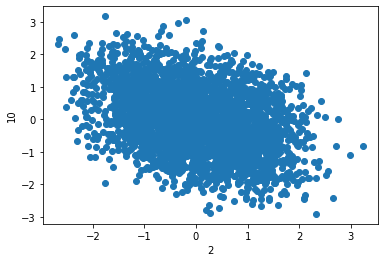

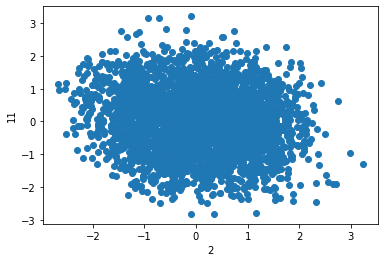

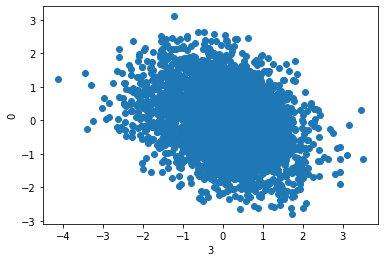

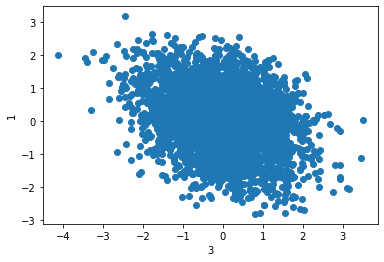

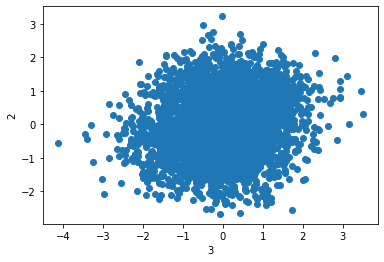

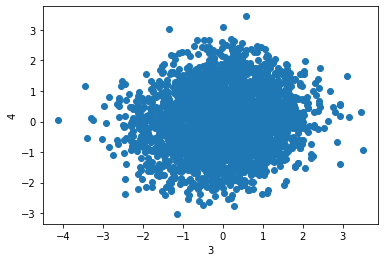

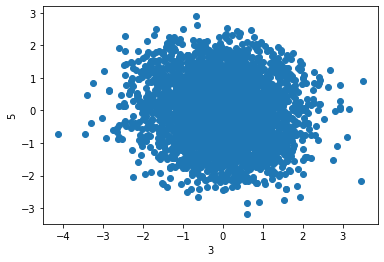

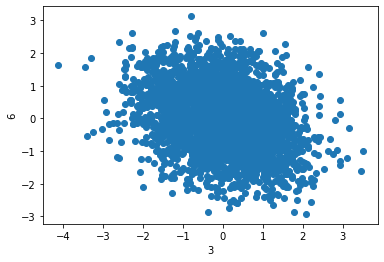

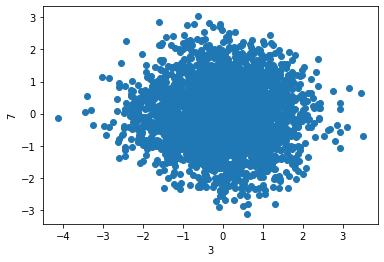

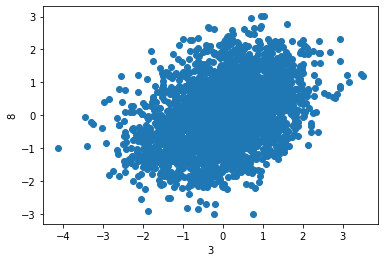

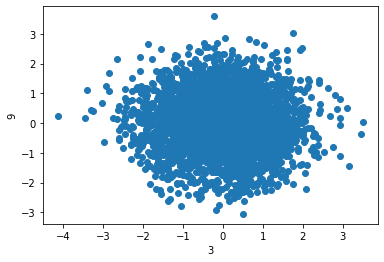

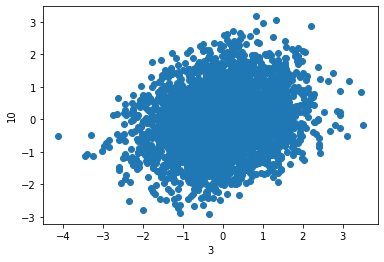

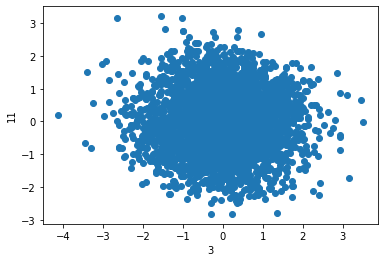

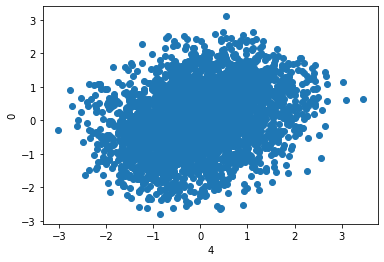

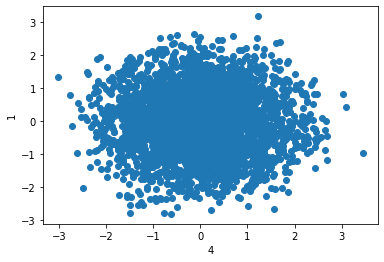

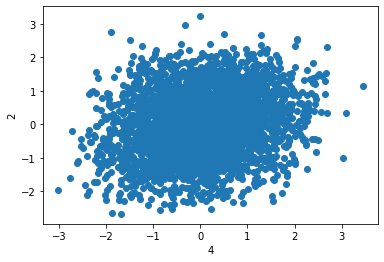

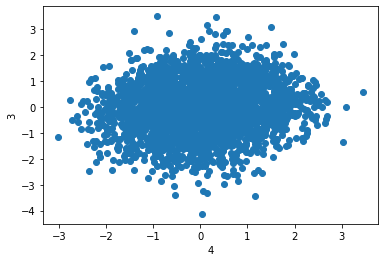

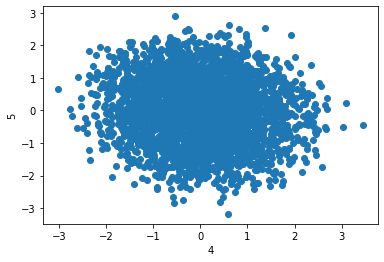

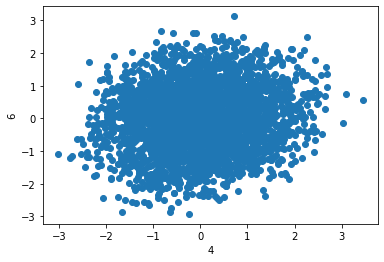

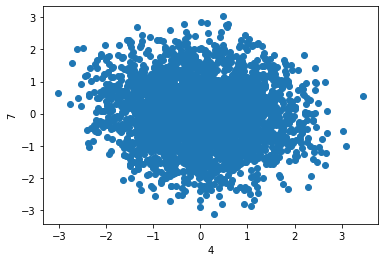

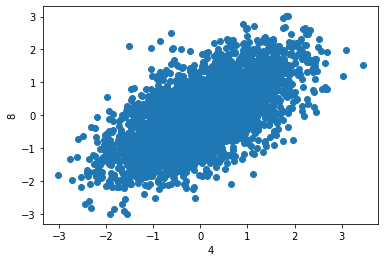

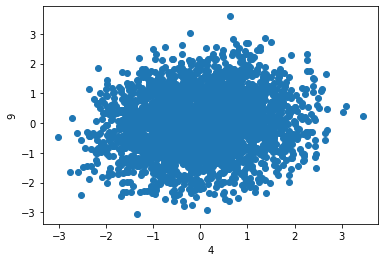

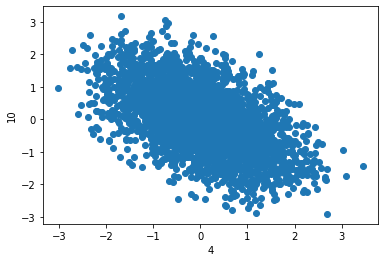

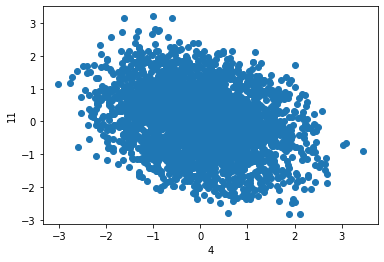

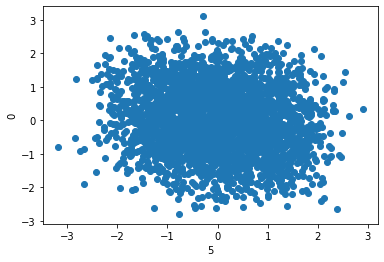

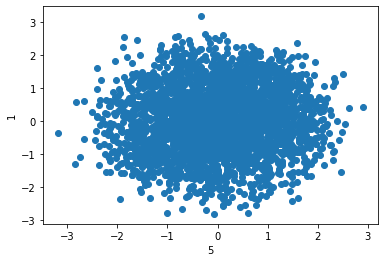

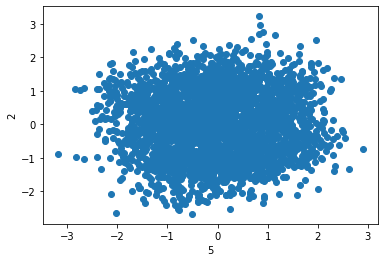

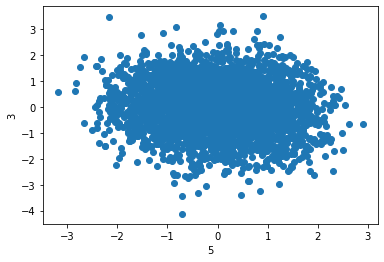

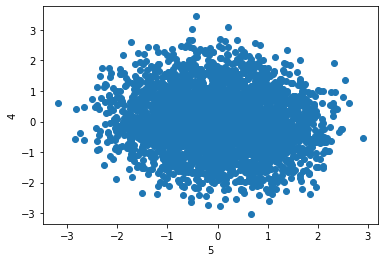

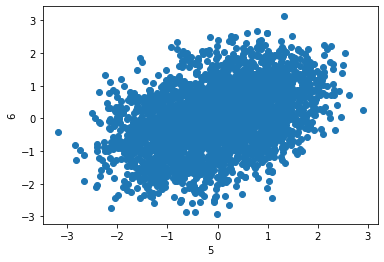

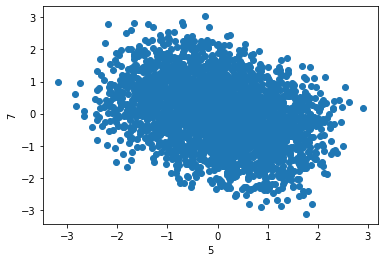

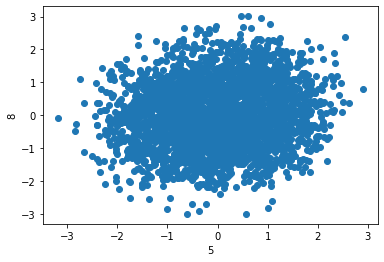

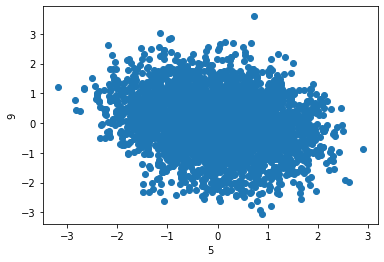

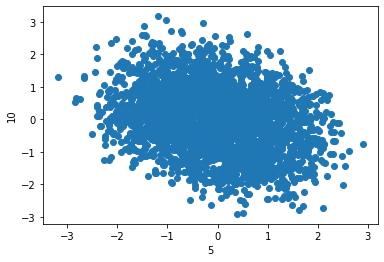

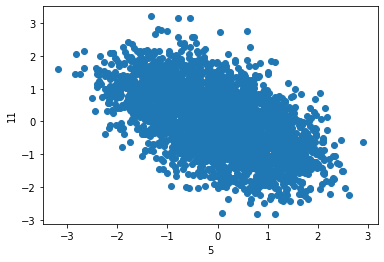

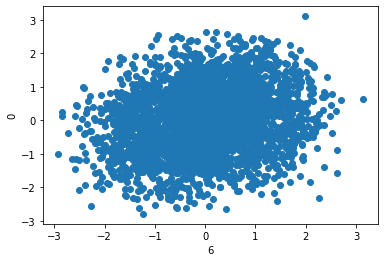

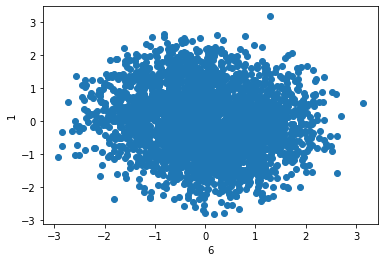

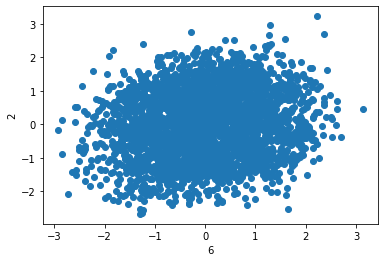

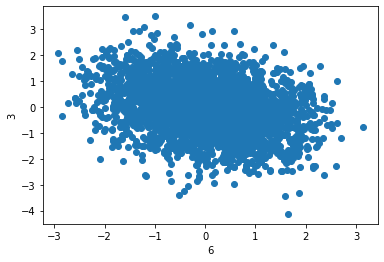

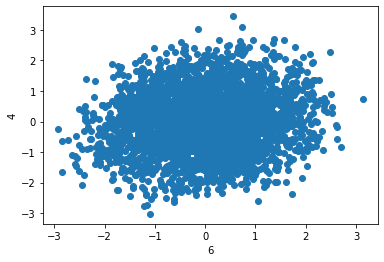

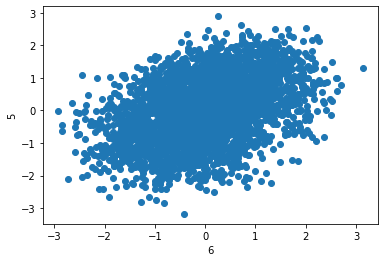

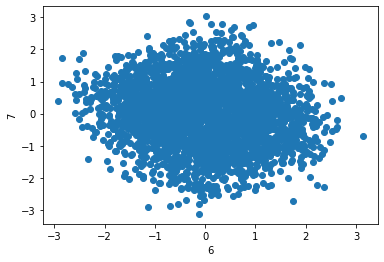

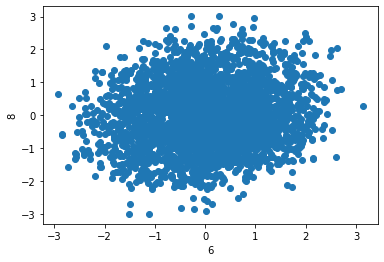

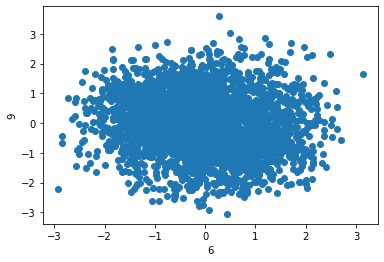

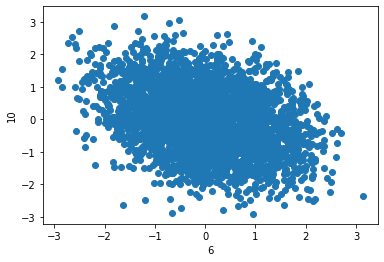

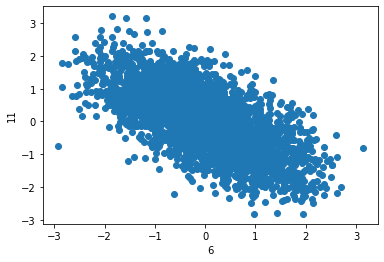

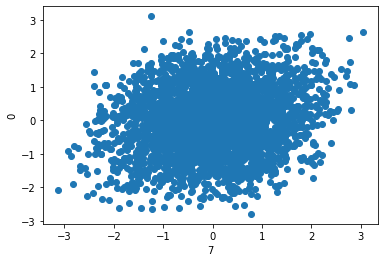

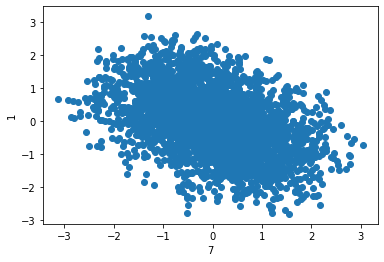

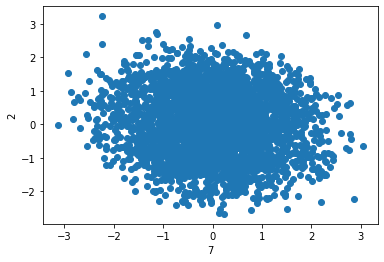

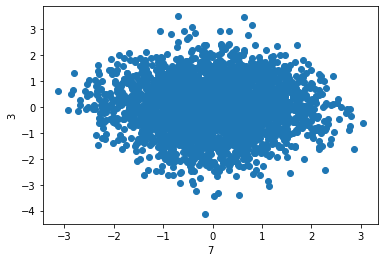

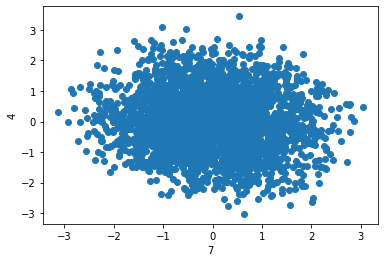

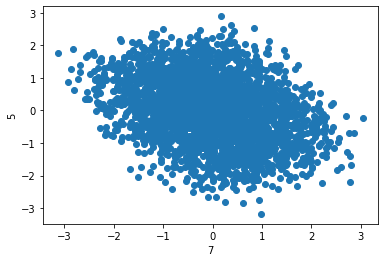

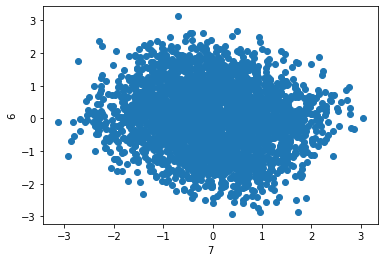

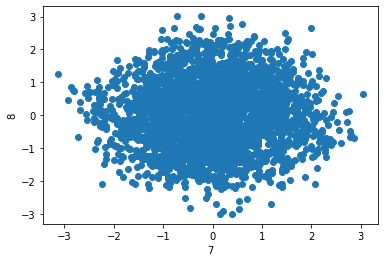

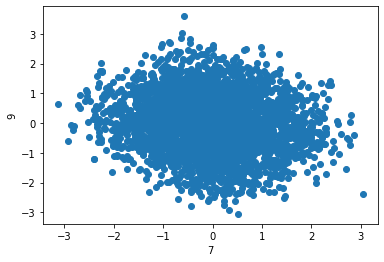

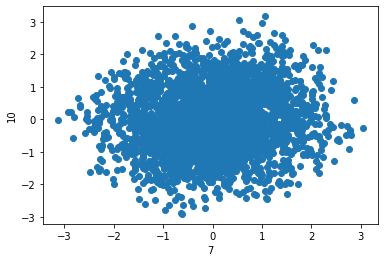

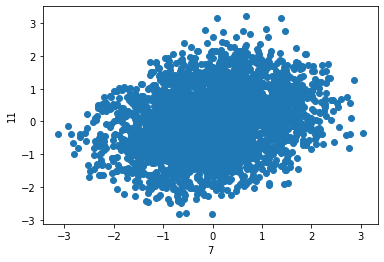

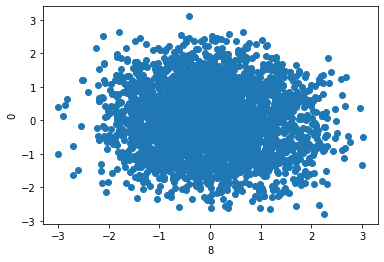

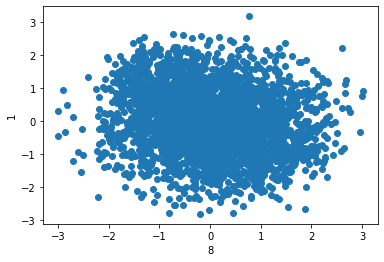

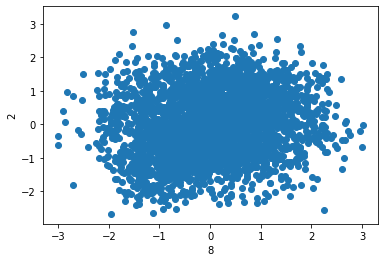

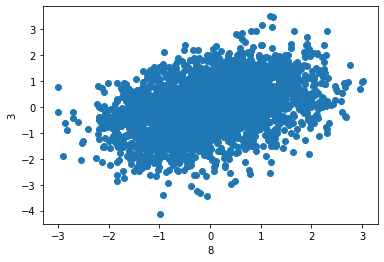

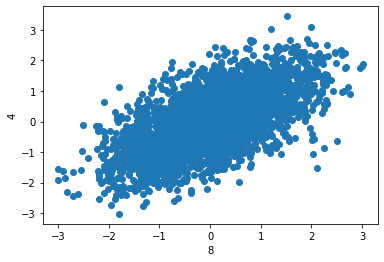

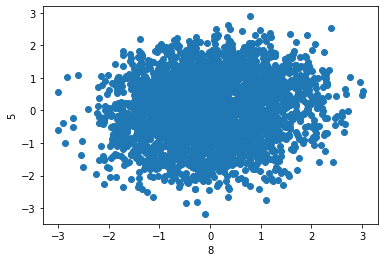

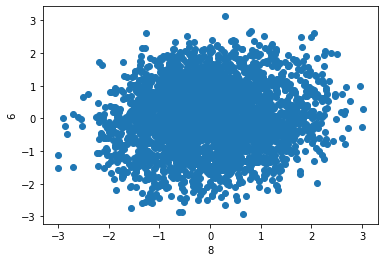

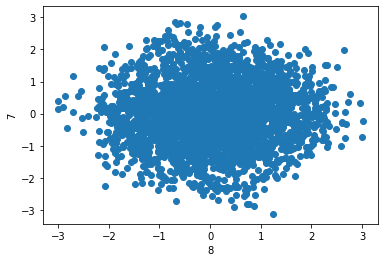

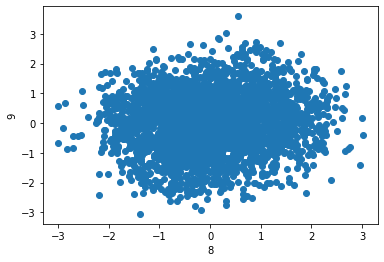

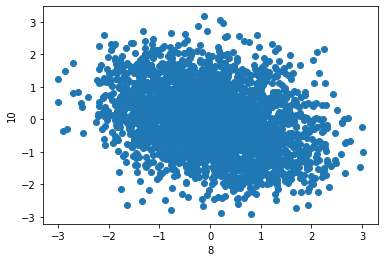

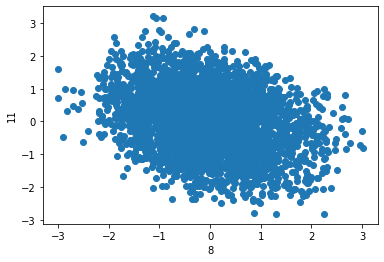

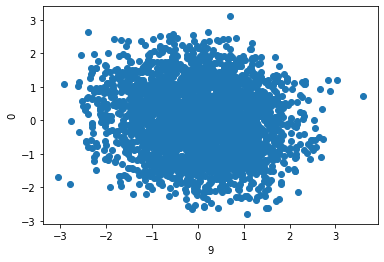

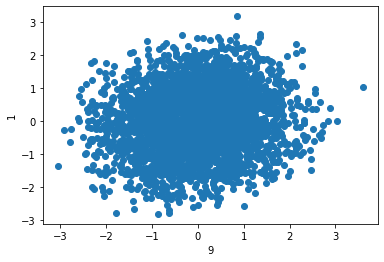

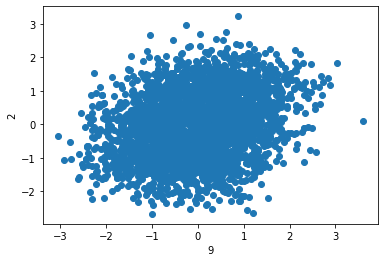

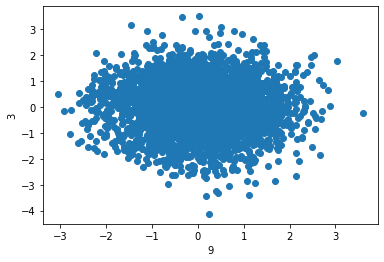

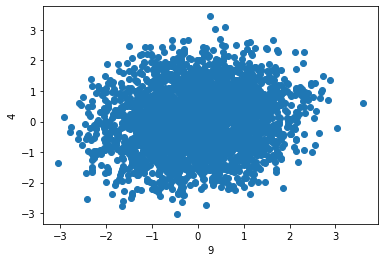

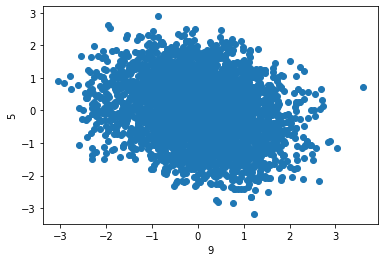

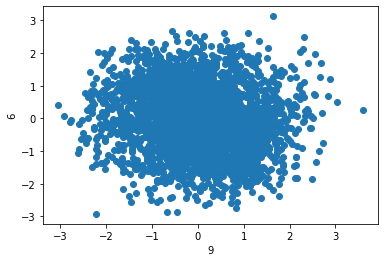

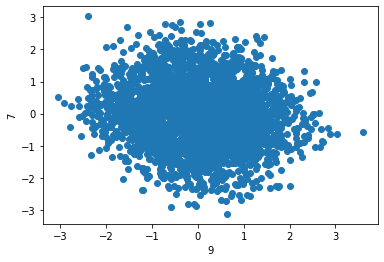

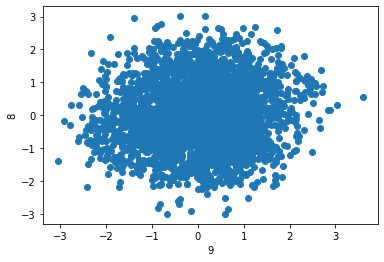

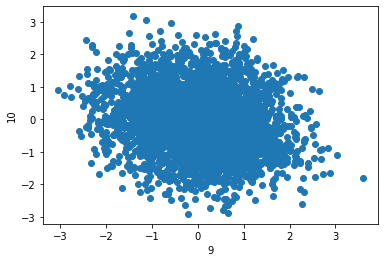

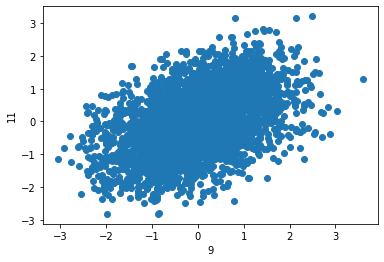

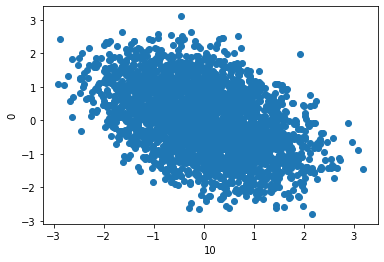

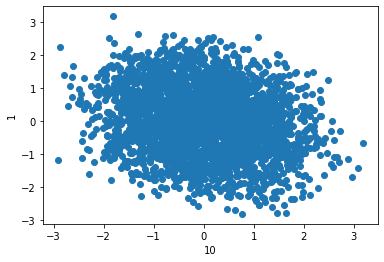

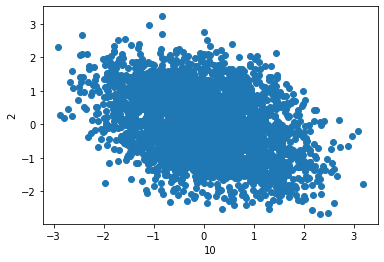

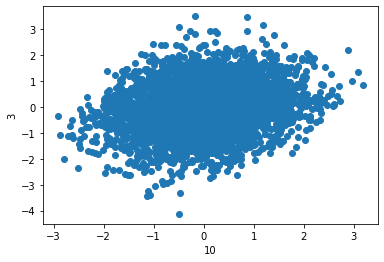

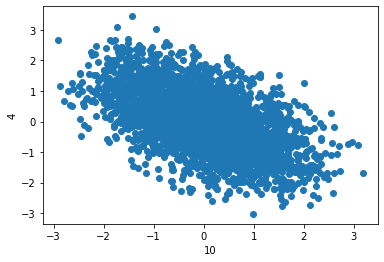

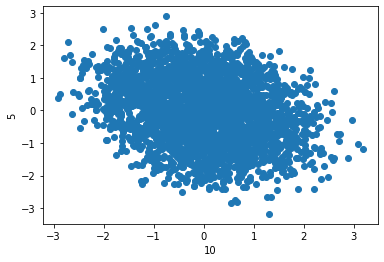

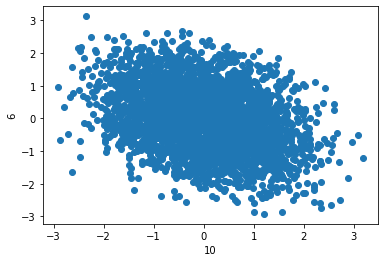

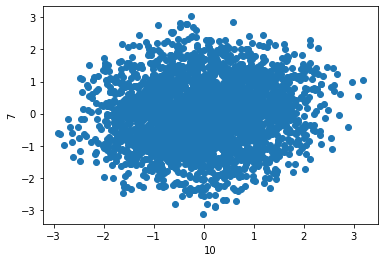

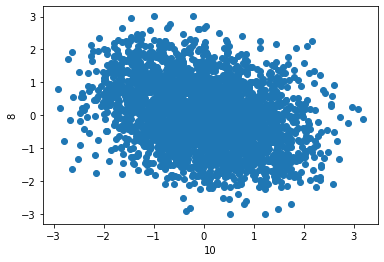

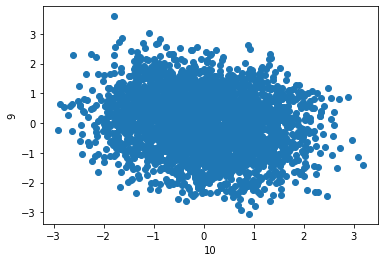

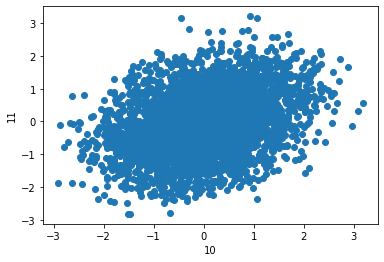

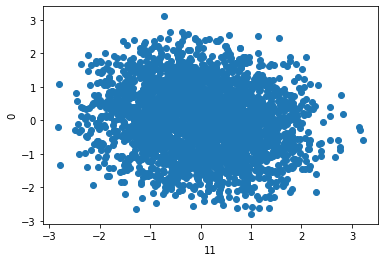

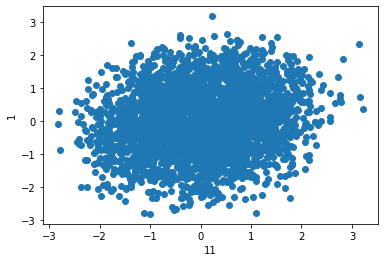

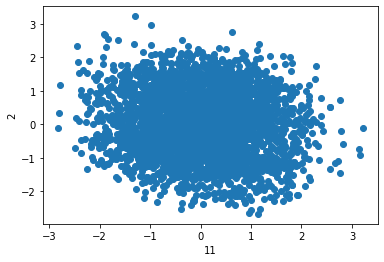

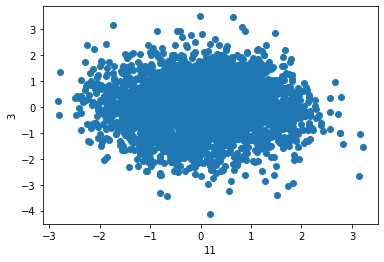

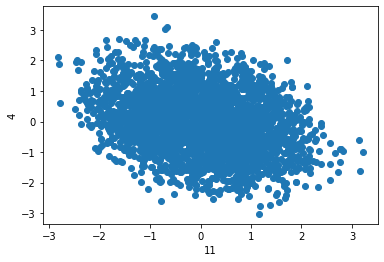

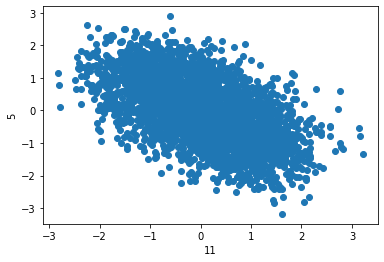

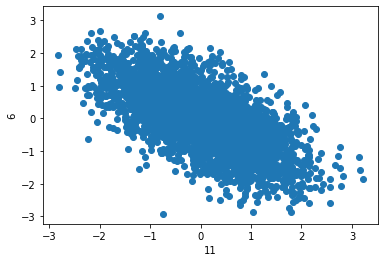

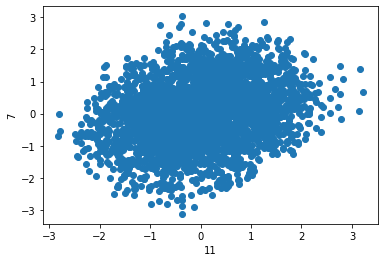

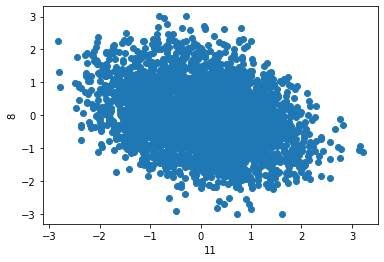

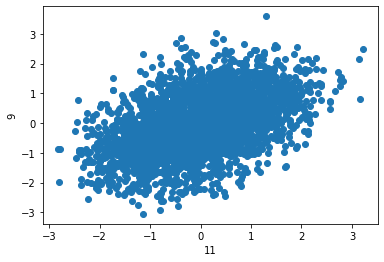

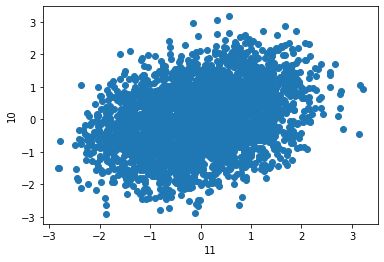

In [57]:
for i in range(12):
    for j in range(12):
        if not i == j:
            plt.xlabel(f"{i}")
            plt.ylabel(f"{j}")
            plt.scatter(data[:, i], data[:, j])
            plt.show()

In [58]:
data = torch.from_numpy(data).float().to(device)
classes = np.hstack([np.zeros(1000), np.ones(1000), np.ones(1000)*2])
classes = torch.from_numpy(classes).long().to(device)
classes

tensor([0, 0, 0,  ..., 2, 2, 2])

In [59]:
dataset = torch.utils.data.TensorDataset(data, classes)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, lengths=(2500, 500))
train_loader = torch.utils.data.DataLoader(train_dataset, drop_last=True, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=True)

In [60]:
class NNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NNModel, self).__init__()
        self.lin1 = nn.Linear(input_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, hidden_dim)
        self.lin3 = nn.Linear(hidden_dim, hidden_dim)
        self.lin4 = nn.Linear(hidden_dim, hidden_dim)
        self.lin5 = nn.Linear(hidden_dim, output_dim)

        self.sigm = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        
        self.norm1 = nn.BatchNorm1d(hidden_dim)
        self.norm2 = nn.BatchNorm1d(hidden_dim)
        self.norm3 = nn.BatchNorm1d(hidden_dim)
        self.norm4 = nn.BatchNorm1d(hidden_dim)

        self.reg1 = nn.Dropout()
        self.reg2 = nn.Dropout(0.4)
        self.reg3 = nn.Dropout(0.3)
        self.reg4 = nn.Dropout(0.2)

    
    def forward(self, x):
        out = self.lin1(x)
        out = self.relu(out)
        out = self.norm1(out)
        # out = self.reg1(out)
    
        out = self.lin2(out)
        out = self.relu(out)
        out = self.norm2(out)
        # out = self.reg2(out)

        out = self.lin3(out)
        out = self.relu(out)
        out = self.norm3(out)
        # out = self.reg3(out)
        
        out = self.lin4(out)
        out = self.relu(out)
        out = self.norm4(out)
        # out = self.reg4(out)

        out = self.lin5(out)
        out = self.softmax(out)
        return out
        
    
input_dim = 12
hidden_dim = 1256
output_dim = 3

In [61]:
model = NNModel(input_dim, hidden_dim, output_dim)
error = nn.CrossEntropyLoss()

In [62]:
learning_rate = 0.05
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.8, weight_decay=0.0008)

In [63]:
epochs = 100
train_loss_list = []
test_loss_list = []
iteration_list = []
accuracy_list = [0]
iteration = 0

for i in range(epochs):
    model.train()
    for train_data, train_classes in train_loader:
        iteration +=1
        
        train = train_data.view(-1, 12)
        train_labels = train_classes
        train_labels = train_labels.type(torch.LongTensor)
        
        optimizer.zero_grad()
        train_pred = model(train)
        
        loss = error(train_pred, train_labels)
        loss.backward()
        
        optimizer.step()
        
        if iteration % 5 == 0:
            total = 0
            correct = 0 
            model.eval()
            for test_data, test_classes in test_loader:
                with torch.no_grad():
                    test = test_data.view(-1, 12)
                    test_labels = test_classes
                    test_labels = test_labels.type(torch.LongTensor)
                
                    test_pred = model(test)
                
                    values, indicies = torch.max(test_pred.data, dim=1)
                
                    total += len(test_labels)
                    correct += (indicies==test_labels).sum().item()
               
                    test_loss = error(test_pred, test_labels)
                
            model.train()
                
            accuracy = correct/total
            train_loss_list.append(loss.item())
            test_loss_list.append(test_loss.item())
            iteration_list.append(iteration)
            accuracy_list.append(accuracy)
        if iteration % 10 == 0:
            print(f"Iteration: {iteration}, Train Loss: {loss.item()}, Test Loss: {test_loss_list[-1]} Accuracy: {accuracy_list[-1]}")
        if iteration > 240:
            break
    if accuracy_list[-1] >= 0.8:
        print("accuracy >= 0.8", iteration)
        break
    if iteration > 240:
        break

Iteration: 10, Train Loss: 0.8477180600166321, Test Loss: 0.9943287968635559 Accuracy: 0.626
Iteration: 20, Train Loss: 0.8856430649757385, Test Loss: 0.893263041973114 Accuracy: 0.63
Iteration: 30, Train Loss: 0.9106899499893188, Test Loss: 0.9258227348327637 Accuracy: 0.646
Iteration: 40, Train Loss: 0.7561940550804138, Test Loss: 0.9236722588539124 Accuracy: 0.662
Iteration: 50, Train Loss: 0.8456496000289917, Test Loss: 0.8743282556533813 Accuracy: 0.65
Iteration: 60, Train Loss: 0.7914592623710632, Test Loss: 0.8898977041244507 Accuracy: 0.62
Iteration: 70, Train Loss: 0.8278766870498657, Test Loss: 0.8631900548934937 Accuracy: 0.66
Iteration: 80, Train Loss: 0.809836208820343, Test Loss: 0.8635851740837097 Accuracy: 0.664
Iteration: 90, Train Loss: 0.8079572916030884, Test Loss: 0.8307011127471924 Accuracy: 0.66
Iteration: 100, Train Loss: 0.7467296123504639, Test Loss: 0.813698947429657 Accuracy: 0.672
Iteration: 110, Train Loss: 0.7651621699333191, Test Loss: 0.881201446056366 

In [64]:
correct = 0
total = 0
for test, test_classes in test_loader:
    test = test.view(-1, 12)
    test_labels = test_classes
    test_labels = test_labels.type(torch.LongTensor)
    
    test_pred = model(test)

    values, indicies = torch.max(test_pred.data, dim=1)
                
    total += len(test_labels)
    correct += (indicies==test_labels).sum().item()

print(correct/total)

0.656


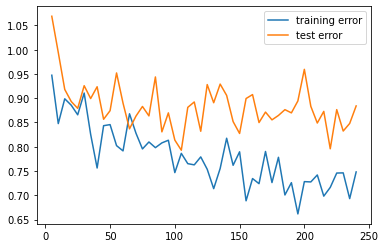

In [65]:
plt.plot(iteration_list, train_loss_list, label="training error")
plt.plot(iteration_list, test_loss_list, label="test error")
plt.legend()
plt.show()

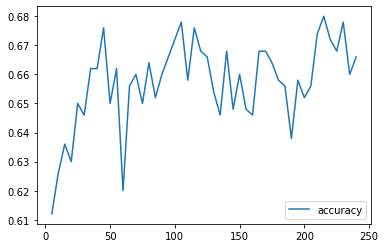

In [66]:
plt.plot(iteration_list, accuracy_list[1:], label="accuracy")
plt.legend()
plt.show()

In [67]:
torch.save(model.state_dict(), "trained_model.pt")

In [68]:
new_model  = NNModel(input_dim, hidden_dim, output_dim)
new_model.load_state_dict(torch.load("trained_model.pt"))
new_model.eval()

NNModel(
  (lin1): Linear(in_features=12, out_features=1256, bias=True)
  (lin2): Linear(in_features=1256, out_features=1256, bias=True)
  (lin3): Linear(in_features=1256, out_features=1256, bias=True)
  (lin4): Linear(in_features=1256, out_features=1256, bias=True)
  (lin5): Linear(in_features=1256, out_features=3, bias=True)
  (sigm): Sigmoid()
  (relu): ReLU()
  (softmax): Softmax(dim=1)
  (norm1): BatchNorm1d(1256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm2): BatchNorm1d(1256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm3): BatchNorm1d(1256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm4): BatchNorm1d(1256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (reg1): Dropout(p=0.5, inplace=False)
  (reg2): Dropout(p=0.4, inplace=False)
  (reg3): Dropout(p=0.3, inplace=False)
  (reg4): Dropout(p=0.2, inplace=False)
)